In [1]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
import boto3
import os
from dotenv import load_dotenv
import pandas as pd
import random
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_experimental.synthetic_data import create_data_generation_chain
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from typing import List

from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser

from langgraph.graph import END, StateGraph
from IPython.display import Image
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod


from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


### load credentials

In [2]:
load_dotenv()

True

## load test data

In [3]:
test_data_path = "df_test_v1.xlsx"
test_data = pd.read_excel(test_data_path)
test_data.head(2)

,instance,easy_form_widget_response_id,updated_at,easy_form_id,easy_form_widget_id,easy_form_response_id,user_submitted_description,easy_form_widget_response_type,backing_attribute,field_name,...,subject_type,status,easy_form_name,easy_form_model,easy_form_status,easy_form_description,form_type,requistion_line_id,header_id,channel
0,cbre,NaN,2023-11-01 11:09:43,NaN,NaN,NaN,"""Warning Trip Hazard"" Sign 210mm x 148mm",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,freeform,5889876.0,3013667.0,freeform
1,monash,NaN,2023-09-11 00:20:35,NaN,NaN,NaN,DEBDEN DAYPLANNER refil,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,freeform,1091278.0,479534.0,freeform


### generate synthetic data

In [4]:
def initialize_llm(**kwargs):
    # initialize llm
    llm = AzureChatOpenAI(
        deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        **kwargs
    )
    return llm

llm= initialize_llm(temperature = 0.9)

### define personas

In [5]:
all_personas = ['verbose','concise','step-by-step','casual','formal','spelling-mistake']
personas_attributes = {
    'verbose':
        'This persona prefers to write longer, complete sentences that are friendly and generally include proper punctuation. They tend to provide detailed explanations with a warm tone.',
    'concise':
        'This persona opts for direct queries with minimal non-essential text. They typically omit filler phrases to convey information efficiently.',
    'step-by-step':
        'This persona summarizes the goal of each step before delving into detailed instructions. They provide clear, sequential guidance to aid understanding.',
    'casual':
        'This persona uses informal language and may not directly reference all the details. They communicate in a relaxed manner, prioritizing ease of comprehension over formality.',
    'formal':
        'This persona prefers to provide detailed information using formal language. They strive for precision and clarity, often employing professional terminology.',
    'spelling-mistake':
        'This persona frequently makes spelling mistakes in their writing.'
}


In [6]:
prompt = PromptTemplate.from_template("""You are an employee in a corporate business and you have the responsibility to purchase or procure goods or services for your organization.
You will be provided with a description of the item or service you need to request.
Your task is to present this request to an AI Assistant.
Use any crucial information such as quantity, amount, business justification, etc., from the provided fields to create a succinct one-line request.
Keep your request short and simple. Use the given description wisely and incorporate only the significant details.
You may add more information if necessary. If there are any extra preferences provided, utilize them while framing your sentence.
Instructions:
-You are a user whose persona aligns with the given persona description. Behave accordingly.
Item or Service Description: {item_description}
Persona Description: {persona_description}
Request:""")

generate = create_data_generation_chain(llm, prompt)

### reflection

In [7]:
llm_reflection = initialize_llm(temperature=0.5 , streaming=True)

reflection_template="""
Task: Assess the correspondence between the "Generated Query" and the specified "Persona Description" within the context of training a chatbot for procurement requests.
Objective: Evaluate whether the "Generated Query" accurately represents the attributes outlined in the "Persona Description". Errors can occur anywhere within the entire query, not just limited to the item description. Thus, it's essential to scrutinize each word and sentence structure in the "Generated Query".
important - For instance, if the Persona Description states that the user tends to make spelling mistakes, then a valid 'Generated Query' will have at least one spelling mistake.
Similarly, if the Persona Description indicates that the user writes formally, then a valid 'Generated Query' generated query should not have any casual or informal tone.
Original Item or Service Description: {item_description}
Persona Description (User Making the Request): {persona_description}
Generated Query: {generated_query}
important - For instance, if the Persona Description states that the user tends to make spelling mistakes, then a valid 'Generated Query' will have at least one spelling mistake.
Similarly, if the Persona Description indicates that the user writes formally, then a valid 'Generated Query' generated query should not have any casual or informal tone.

\n{format_instructions}\n"""


class IsQueryValid(BaseModel):
    observation: str = Field(description="all observations")
    valid: bool = Field(description="whether 'Generated Query' is valid")
    action: str = Field(description="Detailed Recommended actions")

# Set up a parser + inject instructions into the prompt template.
reflection_parser = PydanticOutputParser(pydantic_object=IsQueryValid)

reflection_prompt = PromptTemplate(
    template=reflection_template,
    input_variables=['item_description', 'persona_description', 'generated_query'],
    partial_variables={"format_instructions": reflection_parser.get_format_instructions()},
)
reflection_chain = reflection_prompt | llm_reflection | reflection_parser

In [8]:
prompt_after_reflection = PromptTemplate.from_template("""Your task is to refine the provided sentence following the guidance provided below.
Original sentence: {generated_query}
This sentence was authored by an individual characterized by the following attributes: {persona_description}. 
However, upon review, it's evident that the sentence does not accurately represent these attributes. Thus, it necessitates modification based on the following observation and recommended actions:
Observation: {observation}
To rectify this discrepancy, the following action should be taken: {action}

""")

generate_after_reflection_chain = create_data_generation_chain(llm, prompt_after_reflection)

### create graph

In [9]:
class AgentState(TypedDict):
    item_description:str
    persona_description:str
    generated_query:str
    valid:bool
    observation:str
    action:str
    iterations:int

In [10]:
def generate_synthetic_query(state):
    print('state:', state)
    args ={}
    args['item_description']=state['item_description']
    args['persona_description']=state['persona_description']
    generated_query = generate.invoke(args)['text']
    return {"generated_query":generated_query}

def reflect(state):
    args ={}
    args['item_description']=state['item_description']
    args['persona_description']=state['persona_description']
    args['generated_query']=state['generated_query']
    reflection_res = reflection_chain.invoke(args)
    return reflection_res.__dict__


def should_continue(state):
    max_iterations=3
    if state['valid']==True or state['iterations']>=max_iterations:
        print('Ending as generated query is valid or max iterations reached')
        return "end"
    else:
        print('Contining to generation')
        return "continue"
    
def generate_after_reflection(state):
    args ={}
    args['generated_query']=state['generated_query']
    args['persona_description']=state['persona_description']
    args['observation']=state['observation']
    args['action']=state['action']
    generated_query_after_reflection = generate_after_reflection_chain.invoke(args)['text']
    print(generated_query_after_reflection)

    return {"generated_query":generated_query_after_reflection,
            "iterations":state['iterations']+1}

In [11]:
workflow = StateGraph(AgentState)

# create nodes
workflow.add_node("initial_generation",generate_synthetic_query)
workflow.add_node("reflect",reflect)
workflow.add_node("generation_after_reflection",generate_after_reflection)


workflow.set_entry_point("initial_generation")

# add conditional edge
workflow.add_conditional_edges(
    "reflect",
    should_continue,
    {"continue":"generation_after_reflection",
    "end":END
    }
)
# add a normal edge
# because we always want to go to the agent after going to the action
workflow.add_edge("initial_generation","reflect")
workflow.add_edge("generation_after_reflection","reflect")

app = workflow.compile()

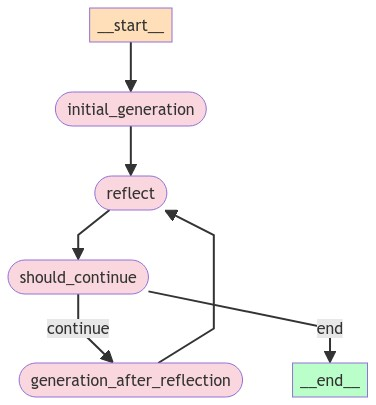

In [12]:
Image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
))

### test graph

In [37]:
test_data.sample(1)['user_submitted_description'].values[0]

'POC Roof Solar System'

In [42]:
item_description =test_data.sample(1)['user_submitted_description'].values[0].replace('"','')
persona = 'spelling-mistake'
persona_description = 'This persona frequently makes spelling mistakes in their writing.'
item_description, persona,persona_description

('Designing Spaces- 2024 Marketing PIO- Do it Yourself, but not Alone; Innovative Home Repair Solutions for Today’s Homeowners',
 'spelling-mistake',
 'This persona frequently makes spelling mistakes in their writing.')

In [43]:

inputs  = {
            "item_description":item_description,
            "persona":persona,
            "persona_description":persona_description,
            "valid":False,
            "iterations":0
            }

In [44]:
for output in app.stream(inputs):
    #print(output)
    for key,value in output.items():
        print(f"output from node {key}")
        print("--------------------------------")
        print(value)
        print("--------------------------------")
        print()

state: {'item_description': 'Designing Spaces- 2024 Marketing PIO- Do it Yourself, but not Alone; Innovative Home Repair Solutions for Today’s Homeowners', 'persona_description': 'This persona frequently makes spelling mistakes in their writing.', 'generated_query': None, 'valid': False, 'observation': None, 'action': None, 'iterations': 0}
output from node initial_generation
--------------------------------
{'generated_query': 'Please assist in procuring the Designing Spaces- 2024 Marketing PIO, a DIY home repair solution for homeowners.'}
--------------------------------

Ending as generated query is valid or max iterations reached
output from node reflect
--------------------------------
{'valid': True, 'observation': 'The generated query accurately represents the attributes outlined in the persona description.', 'action': 'No action recommended.'}
--------------------------------



### Archive

In [ ]:


personas_attributes_string = ""
for key, value in personas_attributes.items():
    personas_attributes_string += "{} = {}\n ".format(key, value)

# To remove the last comma and space
personas_attributes_string = personas_attributes_string[:-2]

print(personas_attributes_string)

In [ ]:
reflection_template="""You are proficient in analyzing, critiquing, and recommending enhancements to the training data used for educating a chatbot on procurement requests.
The chatbot should be capable of generalizing an array of user inquiries.
Below are the specifics regarding the generated query along with the original description utilized to generate the query:
Original Item or Service Description: {item_description}
Persona Description (user making the request): {persona_description}
Generated Query: {generated_query}.

Your task is to analyse and report whether the 'Generated Query' follows the exact attributes of the Persona Description.
\n{format_instructions}\n"""

In [ ]:
reflection_template="""You are proficient in analyzing, critiquing, and recommending enhancements to the training data used for educating a chatbot on procurement requests.
The chatbot should be capable of generalizing an array of user inquiries. It's assumed that the chatbot will only cater to users with the following attributes.
{personas_attributes_string}
Note that only one of these type of user has generated the query.
Below are the specifics regarding the generated query along with the original description utilized to generate the query:
Original Item or Service Description: {item_description}
Persona Description (Individual making the request): {persona_description}
Generated Query: {generated_query}.

Your task is to analyse and report whether the 'Generated Query' follows the exact attributes of the Persona Description.
Note that uppercase/lowercase does not matter which analyzing the 'Generated Query'.
\n{format_instructions}\n"""


In [ ]:

def reset_state(state):
    pass

In [ ]:
def formatted_reflection_res(reflection_result):
    formatted_list_messages =[]
    formatted_list_messages.append(f'observation - {reflection_result.observation}')
    formatted_list_messages.append(f'reason_for_observation - {reflection_result.reason_for_observation}')
    formatted_list_messages.append(f'action - {reflection_result.action}')
    formatted_list_messages.append(f'valid - {reflection_result.valid}')
    return formatted_list_messages

In [ ]:
reflection_template="""You are proficient in analyzing, critiquing, and recommending enhancements to the training data used for educating a chatbot on procurement requests.
The chatbot should be capable of generalizing an array of user inquiries. It's assumed that the chatbot will only cater to users with the following attributes.
{personas_attributes_string}
For instance, if the Persona Description indicates that a user tends to make spelling errors, then at least one spelling mistake should be present in the generated query, otherwise, the query would be deemed invalid.
Similarly, if the persona possesses different traits, the generated query should align with those traits.
Below are the specifics regarding the generated query along with the original description utilized to generate the query:
Original Item or Service Description: {item_description}
Persona Description (Individual making the request): {persona_description}
Generated Query: {text}.
\n{format_instructions}\n"""

In [ ]:


ret = generate.invoke({
                "description": item_description,
                "persona": persona,
                "persona_description":persona_description,
            })